In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

def summary(ndarr):
    print(ndarr)
    print("* shape: {}".format(ndarr.shape))
    print("* min: {}".format(np.min(ndarr)))
    print("* max: {}".format(np.max(ndarr)))
    print("* avg: {}".format(np.mean(ndarr)))
    print("* std: {}".format(np.std(ndarr)))
    print("* unique: {}".format(np.unique(ndarr)))

ndarray是numpy的基本元素，它非常便於我們做矩陣的運算。

我們使用MNIST Dataset來當作我們練習的標的，MNIST包含一包手寫數字的圖片，每張圖片大小為28x28，每一張圖片都是一個手寫的阿拉伯數字包含0到9，並且標記上它所對應的數字。我們的目標就是要利用MNIST做到手寫數字辨識。

在Tensorflow你可以很簡單的得到「處理過後的」MNIST，只要利用以下程式碼，

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_data = mnist.train
valid_data = mnist.validation
test_data = mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


每個`train_data`、`valid_data`、`test_data`都包含兩部分：圖片和標籤。

我們來看一下圖片的部分，`train_data.images`一共有55000張圖，每一張圖原本大小是28x28，不過特別注意這裡的Data已經先做過預先處理了，因此圖片已經被打平成28x28=784的一維矩陣了，另外每個Pixel的值也先做過「Normalization」了，通常會這樣處理，每個值減去128再除以128，所以你可以從以下的`summary`中看到它的最大最小值落在0到1之間，還有這個Dataset也已經做過亂數重排了。

In [3]:
summary(train_data.images)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
* shape: (55000, 784)
* min: 0.0
* max: 1.0
* avg: 0.13070042431354523
* std: 0.30815958976745605
* unique: [ 0.          0.00392157  0.00784314  0.01176471  0.01568628  0.01960784
  0.02352941  0.02745098  0.03137255  0.03529412  0.03921569  0.04313726
  0.04705883  0.0509804   0.05490196  0.05882353  0.0627451   0.06666667
  0.07058824  0.07450981  0.07843138  0.08235294  0.08627451  0.09019608
  0.09411766  0.09803922  0.10196079  0.10588236  0.10980393  0.1137255
  0.11764707  0.12156864  0.1254902   0.12941177  0.13333334  0.13725491
  0.14117648  0.14509805  0.14901961  0.15294118  0.15686275  0.16078432
  0.16470589  0.16862746  0.17254902  0.17647059  0.18039216  0.18431373
  0.18823531  0.19215688  0.19607845  0.20000002  0.20392159  0.20784315
  0.21176472  0.21568629  0.21960786

來試著畫圖來看看，我們使用ndarray的index功能來選出第10張圖片，`train_data.images[10,:]`表示的是選第一軸的第10個和第二軸的全部。

In [4]:
def plot_fatten_img(ndarr):
    img = ndarr.copy()
    img.shape = (28,28)
    plt.imshow(img, cmap='gray')
    plt.show()

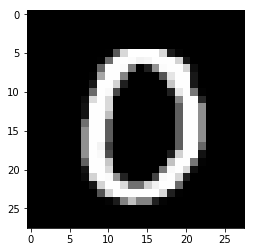

In [5]:
plot_fatten_img(train_data.images[10,:])

很顯而易見的，這是一個0。

接下來來看標籤的部分，`train_data.labels`不意外的一樣的也是有相應的55000筆資料，所對應的就是前面的每一張圖片，總共有10種類型:0到9，所以大小為(55000, 10)。

In [6]:
summary(train_data.labels)

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
* shape: (55000, 10)
* min: 0.0
* max: 1.0
* avg: 0.1
* std: 0.30000000000000004
* unique: [ 0.  1.]


所以我們來看看上面那張圖片的標籤，

In [7]:
print(train_data.labels[10])

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


看起來的確沒錯，在0的位置標示1.，而其他地方標示為0.，因此這是一個標示為0的label沒有錯，這種表示方法稱為One-Hot Encoding，它具有機率的涵義，所代表的是有100%的機會落在0的類別上。

### Softmax

通常One-Hot Encoding會搭配Softmax一同服用，最後的Output結果如果是機率分布，那我也需要讓我的Neurel Network可以輸出機率分布。

![softmax](https://raw.githubusercontent.com/GitYCC/Tensorflow_Tutorial/master/img/TensorflowTutorial.001.jpeg)

通過Softmax這一層，我們就可以將輸出轉變為以「機率」表示。

我們可以來手刻一個Softmax Function，不過直接套用Tensorflow中函數的也是可以的。

In [23]:
import numpy as np

def softmax(x):
    # avoid exp function go to too large,
    # pre-reduce before applying exp function
    max_score = np.max(x,axis=0)
    x = x - max_score
    
    exp_s = np.exp(x)
    sum_exp_s = np.sum(exp_s,axis=0)
    softmax = exp_s / sum_exp_s
    return softmax

scores = [3.0, 1.0, 0.2]
print(softmax(scores))

[ 0.8360188   0.11314284  0.05083836]


### Cross-Entropy Loss

一旦我們要處理機率預測的問題，就不可以使用單純的「平方誤差」，而必須使用Cross-Entropy Loss，是這樣計算的：

Cross-Entropy Loss = -𝚺<sub>i</sub> y<sub>i</sub> ln[ s<sub>i</sub> ]

其中，y<sub>i</sub>為目標Label，s<sub>i</sub>為經過Softmax產生的預測值。

至於如果你想要了解為何需要使用Cross-Entropy Loss？這我在機器學習基石的筆記中已經有提及過，請看[介紹Logistic Regression的部分](http://www.ycc.idv.tw/YCNote/post/27)。

### 分離數據的重要性

在MNIST Dataset中，你會發現分為Training Dataset、Validation Dataset和Testing Dataset，這樣的作法在Machine Learning中是常見且必要的。

流程是這樣的，我們會先使用Training Dataset來訓練Model，並且使用Validation Dataset來檢驗Model的好壞，我們會依據Validation Dataset的檢驗調整Model上的參數，試著盡可能的壓低Validation Dataset的Error，記住！在過程中所產生的所有Models都要保留下來，因為最後選擇的Model並不是Validation Dataset的Error最小的，而是要再由Testing Dataset來做最後的挑選，挑選出能使Testing Dataset的Error最小的Model。

這所有的作法都是為了避免Overfitting的情況發生，也就是機器可能因為看過一筆Data，結果就把這筆Data給完整記了起來，而Data本身含有雜訊，雜訊就這樣滲透到Model裡，確實做到分離是很重要的，讓Model在測試階段時可以使用沒有看過的Data。

因此，Validation Dataset的分離是為了避免讓Model在Training階段看到要驗證的資料，所以更能正確的評估Model的好壞。但這樣是不夠的，人為會根據Validation Dataset來調整Model，這樣無形之中已經將Validation Dataset的資訊間接的經由人傳給了Model，所以還是沒有徹底分離，因此在最後挑選Models時，我們會使用另外一筆從沒看過的資料Testing Dataset來做挑選，一旦挑選完就不能再去調整任何參數了。


### Tensorflow工作流程

我們這一篇將會使用Tensorflow實作最簡單的單層Neurel Network，在這之前我們來看看Tensorflow是如何運作的？

深度學習是由一層一層可以微分的神經元所連接而成，數學上可以表示為張量(Tensor)的表示式，我們一般講的矩陣運算是指2x2的矩陣運算，而張量(Tensor)則是拓寬到n維陣列做計算，在Machine Learning當中我們常常需要處理到相當高維度的計算，例如：有五張28x28的彩色圖的表示就必須使用到四維張量，第一維表示第幾張、第二、三維表示圖片的大小、第四維則表示RGB，如果你是物理系的學生應該也對張量不陌生，廣義相對論裡頭大量的使用四維張量運算，三維空間加一維時間。

而在做Neurel Network時，我們會根據需求不同設計不同形式但合理的流程(Flow)，再使用數據來訓練我的Model。所以，這就是Tensorflow命名由來：Tensor+Flow。

因此，一開始要先設計Model的結構，這在Tensorflow裡頭稱為Graph，Graph的作用是事先決定Neurel Network的結構，決定Neuron要怎麼連接？決定哪一些窗口是可以由外部置放數據的？決定哪一些變數是可以被訓練的？哪一些變數是不可以被訓練的？定義將要怎麼樣優化這個系統？...等等。

In [ ]:
my_graph = tf.Graph() # Initialize a new graph

with my_graph.as_default(): # Create a scope to build graph
    # ...
    # detail of building graph

Graph只是一個結構，它不具有有效的資訊，而當我們定義完成Graph之後，接下來我們需要創造一個環境叫做Session，Session會將Graph的結構複製一份，然後再放入資訊進行Training或是預測等等，因此Session是具有有效資訊的。

In [ ]:
with tf.Session(graph=my_graph) as sess: # Copy graph into session
    # ...
    # detail of doing machine learning  

還有另外一種寫法也是相同作用的，我個人比較喜歡下面這種寫法。

In [ ]:
my_session = tf.Session(graph=my_graph)
my_session.run(...)

### Tensorflow的基本「張量」元素

接下來我們就來看看有哪些構成Graph的基本元素可以使用。

(1) 常數張量：

一開始來看看「常數張量」，常數指的是在Model中不會改變的數值。

In [9]:
tensor = tf.constant([1, 2, 3, 4, 5, 6, 7], dtype=tf.int32)

(2) 變數張量：

與常數截然不同的就是變數，「變數張量」是指在訓練當中可以改變的值，一般「變數張量」會用作於Machine Learning需要被訓練的參數，如果你沒有特別設定，在最佳化的過程中，Tensorflow會自動調整「變數張量」的數值來最佳化。

In [10]:
tensor = tf.Variable( tf.truncated_normal(shape=(3,5)) )

因為變數通常是未知且待優化的參數，所以我們一般會使用Initalizer來設定它的初始值，`tf.truncated_normal(shape=(3,5))`會隨機產生大小3x5的矩陣，它的值呈常態分佈但只取兩個標準差以內的數值。

如果今天你想要有一個「變數張量」但是又不希望它因為最佳化而改變，這時你要特別指定`trainable`為`False`。

In [11]:
tensor = tf.Variable(5, trainable=False)

(3) 置放張量：

另外有一些張量負責擔任輸入窗口的角色，稱為Placeholder。

In [12]:
tensor = tf.placeholder(tf.float32, shape=(None,1000))

因為我們在訓練之前還尚未知道Data的數量，所以這裡使用None來表示未知。`tf.placeholder`在Graph階段是沒有數值的，必須等到Session階段才將數值給輸入進去。

(4) 操作型張量：

這類張量並不含有實際數值，而是一種操作，常用的「操作型張量」有兩種，第一種是作為最佳化使用，

In [ ]:
loss = ...
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)

選擇Optimizer和最佳化的方式來定義最佳化的操作方法，上述的例子是使用learning_rate為0.5的Gradient Descent來降低loss。

另外一種是初始化的操作，

In [13]:
init_op = tf.global_variables_initializer()

這一個步驟是必要的但常常被忽略，還記得剛剛我們定義「變數張量」時有用到Initalizer，這些Initalizer在Graph完成時還不具有數值，必須使用`init_op`來給予數值，所以記住一定要放`init_op`進去Graph裡頭，而且必須先定義完成所有會用到的Initalizer再來設定這個`init_op`。

### Session的操作

「張量」元素具有兩個面向：功能和數值，在Graph階段「張量」只具有功能但不具有數值，只有到了Session階段才開始有數值，那如何將這些數值取出來呢？有兩種方法，以1+1當作範例來看看，

In [14]:
g1 = tf.Graph()
with g1.as_default():
    x = tf.constant(1)
    y = tf.constant(1)
    sol = tf.add(x,y) # add x and y

with tf.Session(graph=g1) as sess: 
    print(sol) # print tensor, not their value

Tensor("Add:0", shape=(), dtype=int32)


In [15]:
with tf.Session(graph=g1) as sess: 
    print(sol.eval()) # evaluate their value

2


In [16]:
s1 = tf.Session(graph=g1)
print(s1.run(sol)) # another way of evaluating value

2


那如果我想使用placeholder來做到x+y呢？

In [17]:
g2 = tf.Graph()
with g2.as_default():
    x = tf.placeholder(tf.int32)
    y = tf.placeholder(tf.int32)
    sol = tf.add(x,y) # add x and y

s2 = tf.Session(graph=g2)

# if x = 2 and y = 3
print(s2.run(sol,feed_dict={x: 2,y: 3})) 

5


In [18]:
# if x = 5 and y = 7
print(s2.run(sol,feed_dict={x: 5,y: 7})) 

12


因為x和y是placeholder，所以必須使用`feed_dict`來餵入相關資訊，否則會報錯。

### 第一個Tensorflow Model

有了以上的認識我們就可以來建立我們第一個Model。

以下我會使用物件導向的寫法，讓程式碼更有條理。

Machine Learning在操作上可以整理成三個大步驟：建構(Building)、訓練(Fitting)和推論(Inference)，所以我們將會使用這三大步驟來建製我們的Model。

在`SimpleLogisticClassification`裡頭，「建構」的動作在`__init__`中會進行，由`build`函式來建立Graph，其中我將Neurel Network的結構分離存於`structure`裡。「訓練」的動作在`fit`中進行，這裡採用傳統的Gradient Descent的方法，將所有Data全部考慮進去最佳化，未來會再介紹Batch Gradient Descent。最後，「推論」的部分在`predict`和`evaluate`中進行。

`SimpleLogisticClassification`將會建構一個只有一層的Neurel Network，也就是說沒有Hidden Layer，畫個圖。

![Simple Logistic Classification](https://raw.githubusercontent.com/GitYCC/Tensorflow_Tutorial/master/img/TensorflowTutorial.002.jpeg)

In [21]:
class SimpleLogisticClassification(object):
    def __init__(self,n_features,n_labels,learning_rate=0.5):
        self.n_features = n_features
        self.n_labels = n_labels
        
        self.weights = None
        self.biases  = None
        
        self.graph = tf.Graph() # initialize new graph
        self.build(learning_rate) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph     
    
    def build(self,learning_rate):
        # Building Graph
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None,self.n_features))
            self.train_labels   = tf.placeholder(tf.int32  , shape=(None,self.n_labels))
            
            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_,self.loss = self.structure(features=self.train_features,
                                                        labels=self.train_labels)
            # define training operation
            self.train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)
            
            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None,self.n_features))
            self.new_labels   = tf.placeholder(tf.int32  , shape=(None,self.n_labels))
            self.new_y_,self.new_loss = self.structure(features=self.new_features,
                                                       labels=self.new_labels,)
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()
            
    def structure(self,features,labels):
        # build neurel network structure and return their predictions and loss
        ### Variable
        if (not self.weights) or (not self.biases):
            self.weights = {
                'fc1': tf.Variable(tf.truncated_normal( shape=(self.n_features,self.n_labels) )),
            }
            self.biases  = {
                'fc1': tf.Variable(tf.zeros( shape=(self.n_labels) )),
            } 
            
        ### Structure   
        # one fully connected layer
        logits = self.getDenseLayer(features,self.weights['fc1'],self.biases['fc1'])
        
        # predictions
        y_ = tf.nn.softmax(logits)
        
        # loss: softmax cross entropy
        loss = tf.reduce_mean(
                 tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits))

        return (y_,loss)
    
    def getDenseLayer(self,input_layer,weight,bias,activation=None):
        # fully connected layer
        x = tf.add(tf.matmul(input_layer,weight),bias)
        if activation:
            x = activation(x)
        return x
    
    def fit(self,X,y,epochs=10,validation_data=None,test_data=None):
        X = self._check_array(X)
        y = self._check_array(y)
        
        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print("Epoch %2d/%2d: "%(epoch+1,epochs))
            
            # fully gradient descent
            feed_dict = {self.train_features: X, self.train_labels: y}
            _ = self.sess.run(self.train_op, feed_dict=feed_dict)
            
            # evaluate at the end of this epoch
            y_ = self.predict(X)
            train_loss = self.evaluate(X,y)
            train_acc = self.accuracy(y_,y)
            msg = " loss = %8.4f, acc = %3.2f%%" % ( train_loss, train_acc*100 )
            
            if validation_data:
                val_loss = self.evaluate(validation_data[0],validation_data[1])
                val_acc = self.accuracy(self.predict(validation_data[0]),validation_data[1])
                msg += ", val_loss = %8.4f, val_acc = %3.2f%%" % ( val_loss, val_acc*100 )
            
            print(msg)
            
        if test_data:
            test_acc = self.accuracy(self.predict(test_data[0]),test_data[1])
            print("test_acc = %3.2f%%" % (test_acc*100))
            
    def accuracy(self, predictions, labels):
        return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0])
    
    def predict(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X})
    
    def evaluate(self,X,y):
        X = self._check_array(X)
        y = self._check_array(y)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X, self.new_labels: y})
    
    def _check_array(self,ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape)==1: ndarray = np.reshape(ndarray,(1,ndarray.shape[0]))
        return ndarray
    

In [22]:
model = SimpleLogisticClassification(n_features=28*28,
                                     n_labels=10,
                                     learning_rate= 0.5,)
model.fit(X=train_data.images,
          y=train_data.labels,
          epochs=10,
          validation_data=(valid_data.images,valid_data.labels),
          test_data=(test_data.images,test_data.labels), )

Epoch  1/10: 
 loss =   9.4080, acc = 12.45%, val_loss =   9.3869, val_acc = 12.78%
Epoch  2/10: 
 loss =   8.2898, acc = 14.57%, val_loss =   8.2863, val_acc = 14.66%
Epoch  3/10: 
 loss =   7.4517, acc = 16.82%, val_loss =   7.4578, val_acc = 16.74%
Epoch  4/10: 
 loss =   6.8298, acc = 19.23%, val_loss =   6.8352, val_acc = 19.10%
Epoch  5/10: 
 loss =   6.3458, acc = 21.83%, val_loss =   6.3448, val_acc = 21.12%
Epoch  6/10: 
 loss =   5.9372, acc = 24.16%, val_loss =   5.9287, val_acc = 23.64%
Epoch  7/10: 
 loss =   5.5760, acc = 26.53%, val_loss =   5.5604, val_acc = 25.98%
Epoch  8/10: 
 loss =   5.2527, acc = 28.88%, val_loss =   5.2306, val_acc = 28.42%
Epoch  9/10: 
 loss =   4.9624, acc = 31.05%, val_loss =   4.9344, val_acc = 30.54%
Epoch 10/10: 
 loss =   4.7012, acc = 33.06%, val_loss =   4.6681, val_acc = 32.52%
test_acc = 32.77%
